#### 1. Импорты + insttall  Bertopic + загрузка  russian_stopwords
 DictToDataFrameParser класс  из пакета module,  преобразует json в  df

In [329]:
import warnings
import nltk
import torch
import  numpy as np
import re
import pandas as pd

from typing import Optional

from  module import DictToDataFrameParser

from transformers import AutoTokenizer, pipeline
from pathlib import Path


from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from nltk.corpus import stopwords  


In [13]:
try:
    from bertopic import BERTopic
except:
    !pip install bertopic
    from bertopic import BERTopic

   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------- ----------- 524.3/726.2 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 726.2/726.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers')

In [5]:
# список необходим для корректной работы  DictToDataFrameParser (class для создания df из json),
columns ={'date': 'date', 'id':'message_id','type':'type', 'from_id': 'from_id', 'actor_id':'actor_id' , 'reply_to_message_id': 'reply_to_message_id',
         'from': 'user_name', 'actor':'user_name_actor'}

In [287]:
# stop words для 'Vectorizers in BERTopic'
try:
    russian_stopwords = stopwords.words("russian") 
except:
    nltk.download("stopwords")
    russian_stopwords = stopwords.words("russian")

In [288]:
pattern  = r'[^\w,.\!? ]'
def cleaned_string(string: str, pattern: str = pattern) -> str: 
    '''
    По умолчанию  удаляются все символы, не являющиеся буквами, цифрами, пробелами и знаками 
                   препинания.
    Замена гиперссылок на  подстроку "гиперссылка"
    '''
    
    string = re.sub(r'https?://\S+', 'гиперсссылка', string)
    return re.sub(pattern, '', string).strip()

###  Загрузка данных 

In [3]:
folder_ignore = '.ipynb_checkpoints'
path_list =[  i for i  in Path.cwd().rglob('*.json') if folder_ignore not in list(i.parent.parts) ]

In [291]:
# Список путей с json
[ (path_list, f'id_path:{i}')   for i, path_list      in enumerate(path_list)]

[(WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/example/result.json'),
  'id_path:0'),
 (WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/дата/result.json'),
  'id_path:1'),
 (WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/маркетинг/result.json'),
  'id_path:2'),
 (WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/менеджмент/result.json'),
  'id_path:3')]

In [310]:
INDEX =len(path_list)
while INDEX >= len(path_list) or INDEX <0:
    INDEX = int(input(f'Введи id_path (число от 0 до {len(path_list)-1})'))
    if INDEX >= len(path_list):
        print( 'Введенное значение превышает допустимый диапазон')

Введи id_path (число от 0 до 3) 1


In [311]:
INDEX

1

In [312]:
df_1 = DictToDataFrameParser(path_list[INDEX], columns)

In [214]:
df_1.df

,date,chat_name,chat_id,sender_id,sender_type,message_id,type,reply_to_message_id,user_name,first_name,last_name,text
0,2025-02-01 22:40:19,💬 Data Practicum Chat,1379846874,200103497,user,266690,service,NaN,Елизавета,Елизавета,,
1,2025-02-02 21:59:34,💬 Data Practicum Chat,1379846874,217302209,user,266691,service,NaN,Agamet Agametov,Agamet,Agametov,
2,2025-02-03 11:28:38,💬 Data Practicum Chat,1379846874,312724902,user,266693,message,NaN,Olga Varavina,Olga,Varavina,Всем большой привет! Приглашаю на свой уютный ...
3,2025-02-03 11:52:20,💬 Data Practicum Chat,1379846874,1349934990,user,266694,message,266689.0,Илья,Илья,,А у тебя когда будет свой канал про аналитику?
4,2025-02-03 11:52:37,💬 Data Practicum Chat,1379846874,1349934990,user,266695,message,NaN,Илья,Илья,,Будешь туда голосовухи пятиминутные постить
...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2025-02-27 14:20:29,💬 Data Practicum Chat,1379846874,345678846,user,267829,service,NaN,Anastasia Shevaldina,Anastasia,Shevaldina,
1003,2025-02-27 18:27:05,💬 Data Practicum Chat,1379846874,295904416,user,267830,message,267820.0,Andrey Novikov,Andrey,Novikov,Может это просто возраст 🤔\n\nА ты на курс гре...
1004,2025-02-27 18:33:30,💬 Data Practicum Chat,1379846874,5459178210,user,267831,message,267830.0,Дмитрий Лукьянов,Дмитрий,Лукьянов,"Может, тебе просто пойти в лес?"
1005,2025-02-27 20:01:03,💬 Data Practicum Chat,1379846874,1763861461,channel,267832,message,NaN,DATA ALUMNI PRACTICUM,DATA,ALUMNI,Книжный клуб «Data Insights!» \n\n «Data Insig...


In [ ]:
text = [i[:511] if len(i) > 512 else i for i  in df_1.df.text.to_list() ]
text = [(cleaned_string(i), num)  for num, i in enumerate (text)if len(i)>3]
text, index_df = zip(*text)

index_df - список индексов для разметки  df (некоторые тексты не вошли  в итоговый корпус)

### 3. Bertopic, инициализация,  пробный topic modeling.

submodels of Bertopic:
1. Embedding Models
2. Dimensionality Reduction(UMAP)
3. Clustering (HDBSCAN)
4. Vectorizers(CountVectorizer)
5. c-TF-IDF (TF-IDF was adjusted to work on a cluster/categorical/topic level instead of a document level)  
6. Fine-tune Topics

In [405]:
##### модель для Embedding Models
# model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
model = "DeepPavlov/rubert-base-cased-conversational"
##### параметры модели понижения размерности
umap_dict = dict(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine')
##### параметры модели кластеризации
hdbscan_dict = dict(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
##### параметры для Vectorizers
vectorizer_dict = dict(stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
##### параметры для TF_IDF
tf_idf_dict = dict(seed_words=["ссылка", "яндекс", "практикум", "стажировка", "курсы",'вакансия'],
                   seed_multiplier=2
                  )
                  
# nr_topics - количество  тем(ориентировочно)
# top_n_words - количество наиболее значимых слов для каждой темы.

In [406]:
class InitBertopic:
    '''
    Инициализирует Bertopic c заданными парамтрами,
     атрибут topic_model-инициализированная модель Bertopic:
     <name_model>.topic_model.fit_transform(text: list[str]) - кластеризация
     <name_model>.topic_model.get_topic_info() - результат
     <name_model>.topic_model.get_topic([int]) - ключевые слова топика
    '''
    
    def __init__(self,
             nr_topics: Optional[int] = None,
             top_n_words: int = 10,   
             model: Optional[str] = None, 
             umap_dict: Optional[dict] = None, 
             hdbscan_dict: Optional[dict] = None,
             vectorizer_dict: Optional[dict] = None, 
             tf_idf_dict: Optional[dict] = None) -> None:

        self.nr_topics = nr_topics
        self.top_n_words = top_n_words
        self.model = model
        self.umap_dict = umap_dict
        self.hdbscan_dict = hdbscan_dict
        self.vectorizer_dict = vectorizer_dict
        self.tf_idf_dict =  tf_idf_dict
        self.bertopic_dict, self.topic_model = self.init_bertopic()
        
    
    def init_bertopic(self):
        embedding_model = pipeline("feature-extraction", model=self.model)
        bertopic_dict = dict(embedding_model=embedding_model, nr_topics= self.nr_topics, top_n_words=self.top_n_words)
            
        if self.umap_dict:
            umap_model = UMAP(**self.umap_dict)
            bertopic_dict['umap_model'] = umap_model
            
        if self.hdbscan_dict:
             hdbscan_model = HDBSCAN(**self.hdbscan_dict)
             bertopic_dict['hdbscan_model'] =  hdbscan_model
            
        if  self.vectorizer_dict:
            vectorizer_model = CountVectorizer(**self.vectorizer_dict)
            bertopic_dict['vectorizer_model'] =   vectorizer_model
            
        if  self.tf_idf_dict:
            ctfidf_model = ClassTfidfTransformer(**self.tf_idf_dict)
            bertopic_dict['ctfidf_model'] =  ctfidf_model

        
        return bertopic_dict, BERTopic(**bertopic_dict)
        
        

        

        

In [407]:
bertopic_model = InitBertopic(nr_topics=20,
               top_n_words=15,
               model=model,
               umap_dict=umap_dict, 
               hdbscan_dict=hdbscan_dict, 
               vectorizer_dict=vectorizer_dict, 
               tf_idf_dict=tf_idf_dict)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [408]:
bertopic_model.bertopic_dict

{'embedding_model': <transformers.pipelines.feature_extraction.FeatureExtractionPipeline at 0x246baf5b8c0>,
 'nr_topics': 20,
 'top_n_words': 15,
 'umap_model': UMAP(metric='cosine', min_dist=0.0, n_components=5, n_neighbors=3),
 'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'vectorizer_model': CountVectorizer(ngram_range=(1, 3),
                 stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                             'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                             'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                             'по', 'только', 'ее', 'мне', ...]),
 'ctfidf_model': ClassTfidfTransformer(seed_words=['ссылка', 'яндекс', 'практикум', 'стажировка',
                                   'курсы', 'вакансия'])}

In [455]:
%%time
topics, probs = bertopic_model.topic_model.fit_transform(text)

CPU times: total: 2min 51s
Wall time: 1min 30s


In [458]:
model_info = info = bertopic_model.topic_model.get_topic_info()
model_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,158,-1_это_всем_ссылка_всем привет,"[это, всем, ссылка, всем привет, привет, спаси...",[3 марта стартует новый поток Карьерного трека...
1,0,178,0_это_просто_ссылка_курс,"[это, просто, ссылка, курс, nda, голосовухи, ф...",[KatyEfr С телефона вот такая ошибка не поня...
2,1,125,1_спасибо_тебе_тебе спасибо_super_ira,"[спасибо, тебе, тебе спасибо, super_ira, ещё, ...","[Ну вот, чувствуется что тут не токсичная атмо..."
3,2,59,2_данных_курсов_яндекс_привет,"[данных, курсов, яндекс, привет, практикума, в...",[Предложение поучаствовать в бетатестировании ...
4,3,42,3_ссылка_nda_заявку_неактивна,"[ссылка, nda, заявку, неактивна, заявку nda, п...",[Не могу подписать NDA Ссылка неактивна. Запро...
5,4,31,4_toprepyndxcbot_toprepyndxcbot toprepyndxcbot...,"[toprepyndxcbot, toprepyndxcbot toprepyndxcbot...","[toprepyndxcbot, toprepyndxcbot, toprepyndxcbot]"
6,5,30,5_яндекс_ритейл_это_тех,"[яндекс, ритейл, это, тех, помогает, интервью,...","[Самая проблема курсов , как я понял у всех, ч..."
7,6,27,6_лс_можешь_гитхаба_утп,"[лс, можешь, гитхаба, утп, напиши, кинуть, вк,...",[Я тоже только по отзывам местных работяг знаю...
8,7,23,7_чате_кофе_правило_чата,"[чате, кофе, правило, чата, сегодня, котики, с...","[Это сообщение считаю неуместным, если тебе нр..."
9,8,22,8_ахахахаха_увеличила репутацию_увеличила_репу...,"[ахахахаха, увеличила репутацию, увеличила, ре...",[Ирина по прежнему лидирует в нашем соревнован...


In [459]:
bertopic_model.topic_model.get_topic(3)

[('ссылка', 0.12140949139642458),
 ('nda', 0.10864577651472243),
 ('заявку', 0.07595376716191302),
 ('неактивна', 0.044454557951856384),
 ('заявку nda', 0.044454557951856384),
 ('подписать', 0.0430092222483835),
 ('ссылка nda', 0.040658134064074695),
 ('ссылка неактивна', 0.038612219623767485),
 ('отправила', 0.03556364636148511),
 ('отправил', 0.03556364636148511),
 ('готова', 0.0344073777987068),
 ('nda ссылка неактивна', 0.03058502750345637),
 ('nda ссылка', 0.03058502750345637),
 ('подписать nda', 0.03058502750345637),
 ('ссылки', 0.028959164717825614)]

In [460]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print(model_info['Representation'])

0                                                                                                                                                                                                                                                                                                                 [это, всем, ссылка, всем привет, привет, спасибо, блин, вопрос, людей, кажется, hr, яндекс, вопросы, пока, ёклмн]
1                                                                                                                                                                                                                                                                                                               [это, просто, ссылка, курс, nda, голосовухи, форма, отправить, файл, какие, вопросы, пока, работает, вчера, раньше]
2                                                                                                                                                               

In [466]:
df_1_clust = df_1.df.join(pd.DataFrame({'num_topic': topics},index=index_df),how='left')

In [468]:
df_1_clust.sample(5)

,date,chat_name,chat_id,sender_id,sender_type,message_id,type,reply_to_message_id,user_name,first_name,last_name,text,num_topic
127,2025-02-04 15:37:00,💬 Data Practicum Chat,1379846874,262309349,user,266827,message,266824.0,Arsen (არსენა) Хабибуллин,Arsen,(არსენა),мазохистичный порыв да,17.0
299,2025-02-06 07:39:23,💬 Data Practicum Chat,1379846874,1745402363,user,267004,message,266752.0,Ирина,Ирина,,И у меня тоже так и не подучилось по ссылке пе...,0.0
520,2025-02-17 12:10:58,💬 Data Practicum Chat,1379846874,348947770,user,267298,message,267289.0,Юлия,Юлия,,Они в Акселерации регулярно появляются),1.0
357,2025-02-08 13:37:32,💬 Data Practicum Chat,1379846874,100092469,user,267071,message,NaN,Irina,Irina,,"грешу этим, да",0.0
802,2025-02-24 11:29:33,💬 Data Practicum Chat,1379846874,60031833,user,267620,message,267619.0,Sergey,Sergey,,Пиво пить?,0.0


### 4. Визуализации

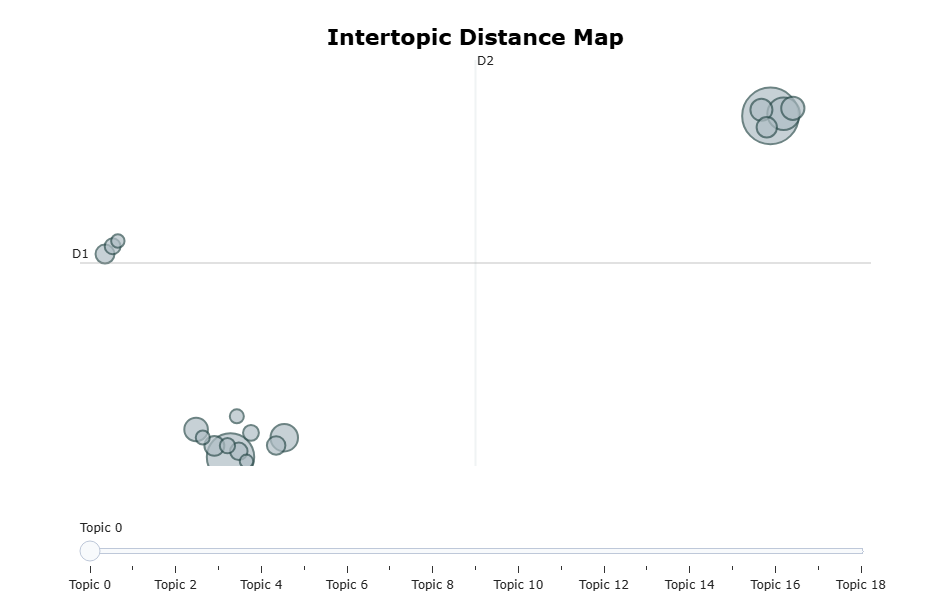

In [474]:
bertopic_model.topic_model.visualize_topics(width = 600, height = 600)

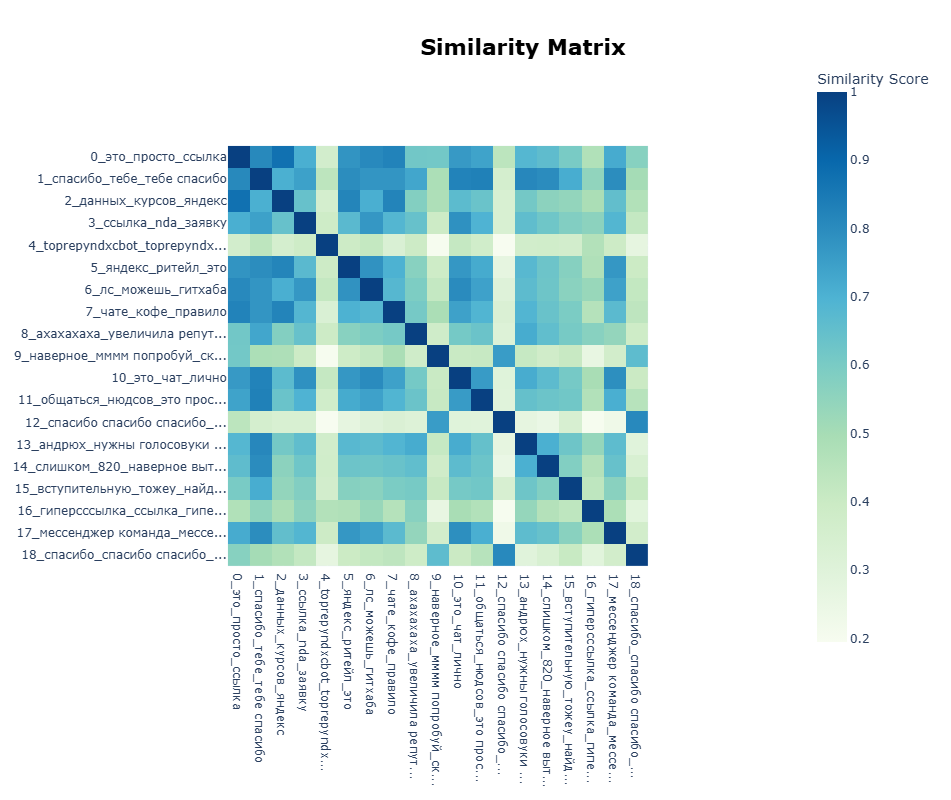

In [476]:
bertopic_model.topic_model.visualize_heatmap()

In [512]:
%%time
timestamps = df_1.df.loc[index_df,:].date.to_list()
topics_over_time = bertopic_model.topic_model.topics_over_time(text, timestamps)
bertopic_model.topic_model.visualize_topics_over_time(topics_over_time)

2025-03-26 20:34:14,549 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 829) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


CPU times: total: 23.5 s
Wall time: 25.2 s
